In [1]:
from IPython.display import clear_output

# Tensorflow GPU

In [2]:
!nvidia-smi

Mon Mar 20 11:55:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      On   | 00000000:22:00.0 Off |                    0 |
| N/A   43C    P0    45W / 250W |      0MiB / 40537MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-PCIE-40GB      On   | 00000000:26:00.0 Off |                    0 |
| N/A   

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-03-20 11:55:09.533409: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 11:55:12.528902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 38427 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:22:00.0, compute capability: 8.0
2023-03-20 11:55:12.531466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:1 with 38427 MB memory:  -> device: 1, name: A100-PCIE-40GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2023-03-20 11:55:12.533800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:2 with 38427 MB memory:  -> device: 2, name: A100-PCIE-40GB, pci bus id: 0000:9e:00.0, compu

# Unet model

### Firts dataset

In [4]:
!pip install gdown
clear_output()

In [4]:
import gdown

url = 'https://drive.google.com/file/d/1-UK0UCBc-XYTnl8wb8QezZMjn7IkgE9g/view?usp=share_link'
output_path = 'archive.zip'
gdown.download(url, output_path, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1-UK0UCBc-XYTnl8wb8QezZMjn7IkgE9g
To: /home/jovyan/archive.zip
100%|██████████| 1.11G/1.11G [00:15<00:00, 72.8MB/s]


'archive.zip'

In [5]:
!unzip archive.zip -d train_dataset

clear_output()

Archive:  archive.zip
replace train_dataset/ct_scans/coronacases_org_001.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [6]:
!rm -r archive.zip

### Second dataset

In [8]:
url = 'https://drive.google.com/file/d/14zCo-090RD6m1dfhPGmrWSCD8UGI1MEz/view?usp=share_link'
output_path = 'Chest_CT_Segmentation.zip'
gdown.download(url, output_path, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=14zCo-090RD6m1dfhPGmrWSCD8UGI1MEz
To: /home/jovyan/Chest_CT_Segmentation.zip
100%|██████████| 1.73G/1.73G [00:27<00:00, 62.3MB/s]


'Chest_CT_Segmentation.zip'

In [ ]:
!unzip Chest_CT_Segmentation.zip -d train_dataset2

clear_output()

In [13]:
!rm -r Chest_CT_Segmentation.zip

rm: cannot remove 'Chest_CT_Segmentation.zip': No such file or directory


In [14]:
!rm -r train_dataset2/pretrained_model

rm: cannot remove 'train_dataset2/pretrained_model': No such file or directory


## [Unet](https://www.kaggle.com/code/samighazouani/task3-lung-mask-segmentation-with-u-net) model 4 - test 1

In [5]:
!pip install keras-segmentation
!pip install -U segmentation-models
!pip install seaborn
!pip install nibabel

clear_output()

In [6]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
import keras_segmentation as ks

warnings.filterwarnings('ignore')
%matplotlib inline
print("Version: ", tf.version.VERSION)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "not available")

Version:  2.6.0
GPU is available


In [7]:
# Read and examine metadata
metadata = pd.read_csv('train_dataset/metadata.csv')
metadata.replace('../input/covid19-ct-scans/', 'train_dataset/', regex=True, inplace=True)
metadata.sample(3)

ct_scan  \
12  train_dataset/ct_scans/radiopaedia_org_covid-1...   
3      train_dataset/ct_scans/coronacases_org_004.nii   
5      train_dataset/ct_scans/coronacases_org_006.nii   

                                            lung_mask  \
12  train_dataset/lung_mask/radiopaedia_14_85914_0...   
3         train_dataset/lung_mask/coronacases_004.nii   
5         train_dataset/lung_mask/coronacases_006.nii   

                                       infection_mask  \
12  train_dataset/infection_mask/radiopaedia_14_85...   
3    train_dataset/infection_mask/coronacases_004.nii   
5    train_dataset/infection_mask/coronacases_006.nii   

                              lung_and_infection_mask  
12  train_dataset/lung_and_infection_mask/radiopae...  
3   train_dataset/lung_and_infection_mask/coronaca...  
5   train_dataset/lung_and_infection_mask/coronaca...

In [8]:
# img_size is the preferred image size to which the image is to be resized
img_size = 512

## Data processing

In [9]:
clahe = cv.createCLAHE(clipLimit=3.0)

def clahe_enhancer(img, clahe, axes):
    '''Contract Limited Adaptive Histogram Equalizer'''
    img = np.uint8(img*255)
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()

    return(clahe_img)

Number of slices:  301


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


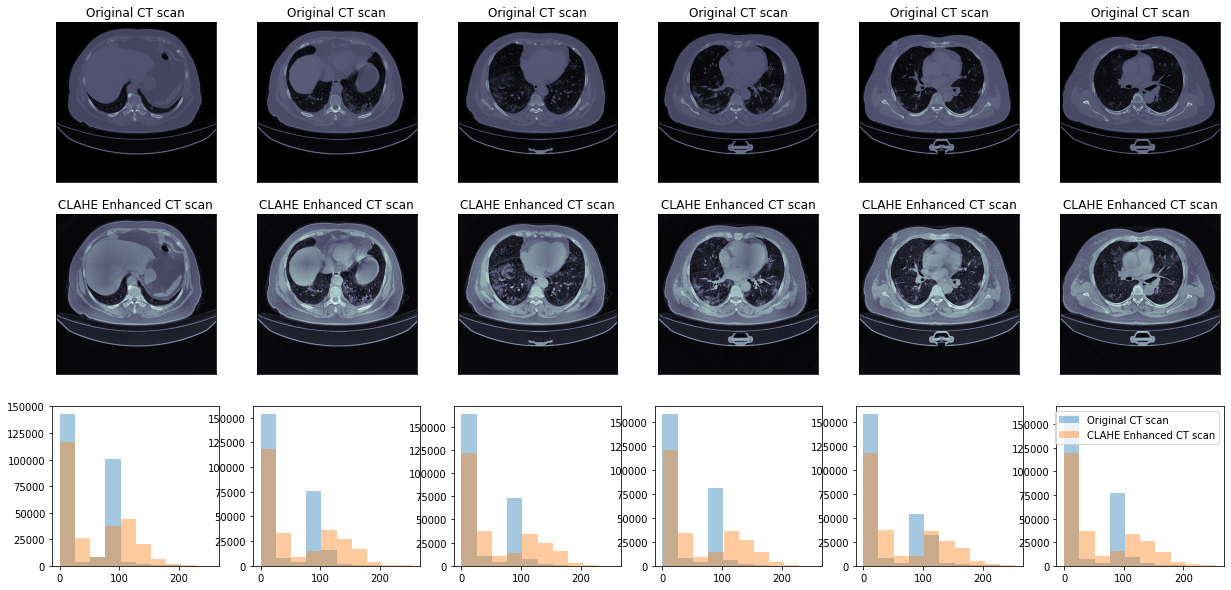

In [10]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)

arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(21,10))

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))

In [11]:
def get_contours(img):
    img = np.uint8(img*255)

    kernel = np.ones((3,3),np.float32)/9
    img = cv.filter2D(img, -1, kernel)

    ret, thresh = cv.threshold(img, 50, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(thresh, 2, 1)
    #Areas = [cv.contourArea(cc) for cc in contours]; print(Areas)

    # filter contours that are too large or small
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) :
        return False # too narrow or wide is bad
    area = cv.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    # margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]

def crop_img(img, axes) :
    contours = get_contours(img)
    #plt.figure() # uncomment to troubleshoot
    #canvas = np.zeros_like(img)
    #cv.drawContours(canvas , contours, -1, (255, 255, 0), 1)
    #plt.imshow(canvas)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

    return cropped_img, bounds

Number of slices:  301


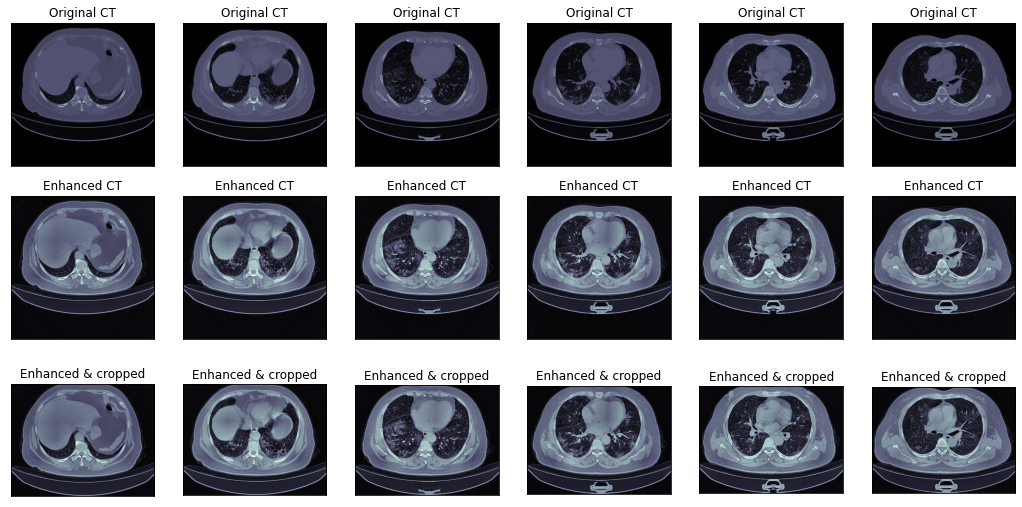

In [17]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)

arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,9))

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    _, bounds = crop_img(img, [])
    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original CT')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])

    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced CT')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    cropped_img = crop_(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Enhanced & cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

### adding dataset 2

In [12]:
df_2 = pd.read_csv('train_dataset2/train.csv')
df_2

ImageId  \
0        ID00007637202177411956430_0.jpg   
1        ID00007637202177411956430_1.jpg   
2        ID00007637202177411956430_2.jpg   
3        ID00007637202177411956430_3.jpg   
4        ID00007637202177411956430_4.jpg   
...                                  ...   
16703  ID00426637202313170790466_403.jpg   
16704  ID00426637202313170790466_404.jpg   
16705  ID00426637202313170790466_405.jpg   
16706  ID00426637202313170790466_406.jpg   
16707  ID00426637202313170790466_407.jpg   

                                       MaskId  
0        ID00007637202177411956430_mask_0.jpg  
1        ID00007637202177411956430_mask_1.jpg  
2        ID00007637202177411956430_mask_2.jpg  
3        ID00007637202177411956430_mask_3.jpg  
4        ID00007637202177411956430_mask_4.jpg  
...                                       ...  
16703  ID00426637202313170790466_mask_403.jpg  
16704  ID00426637202313170790466_mask_404.jpg  
16705  ID00426637202313170790466_mask_405.jpg  
16706  ID00426637202313170790466_mask_406.jpg  
16707  ID00426637202313170790466_mask_407.jpg  

[16708 rows x 2 columns]

In [36]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
lungs = nib.load(metadata.loc[0, 'lung_mask'])
#infec = nib.load(metadata.loc[0, 'infection_mask'])
slices = cts.shape[2]

arr_cts = cts.get_fdata()
arr_lungs = lungs.get_fdata()
#arr_infec = infec.get_fdata()

arr_cts = np.rot90(np.array(arr_cts))
arr_lungs = np.rot90(np.array(arr_lungs))
#arr_infec = np.rot90(np.array(arr_infec))

arr_cts = arr_cts[:, :, range(80,200,20)]
arr_lungs = arr_lungs[:, :, range(80,200,20)]
#arr_infec = arr_infec[:, :, range(80,200,20)]

In [ ]:
from PIL import Image

imgs_ = []
masks_ = []

PATH_TO_IMGS = 'train_dataset2/images/images/'
PATH_TO_MASKS = 'train_dataset2/masks/masks/'

for path in range(df_2.shape[0]):  
    # Preprocess the image and mask data
    img = Image.open(PATH_TO_IMGS+df_2.ImageId[path])
    # img = img.resize((img_size, img_size), Image.LANCZOS)
    imgs_.append(np.array(img))

    msk = Image.open(PATH_TO_MASKS+df_2.MaskId[path])
    # msk = msk.resize((img_size, img_size), Image.LANCZOS)
    masks_.append(np.array(msk))
    
    
imgs_ = np.ndarray(imgs_)
masks_ = np.ndarray(masks_)

In [47]:
imgs_ = np.reshape(np.rollaxis(imgs_, 2),
                     (imgs_.shape[0],imgs_.shape[1],imgs_.shape[2], 1))
masks_ = np.reshape(np.rollaxis(masks_, 2),
                     (masks_.shape[0], masks_.shape[1], masks_.shape[2], 1))

ValueError: cannot reshape array of size 13139705856 into shape (16708,512,512,1)

In [ ]:
imgs_.shape

In [44]:
arr_cts.shape

(6, 512, 512, 1)

In [45]:
arr_lungs.shape

(6, 512, 512, 1)

In [29]:
for i in range(len(imgs_)):
    # adding images and masks from another dataset
    arr_cts = np.concatenate((arr_cts, imgs_[i][..., np.newaxis]), axis=2)
    arr_lungs = np.concatenate((arr_lungs, masks_[i][..., np.newaxis]), axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)

In [28]:
arr_cts = np.concatenate((arr_cts, [..., np.newaxis]), axis=2)
arr_lungs = np.concatenate((arr_lungs, np.array(msk)[np.newaxis, ...]), axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 1 dimension(s)

In [19]:
print(len(imgs_))
assert len(imgs_) == len(masks_)

16708


In [43]:
arr_cts = np.reshape(np.rollaxis(arr_cts, 2),
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2),
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
#arr_infec = np.reshape(np.rollaxis(arr_infec, 2),
                    # (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))

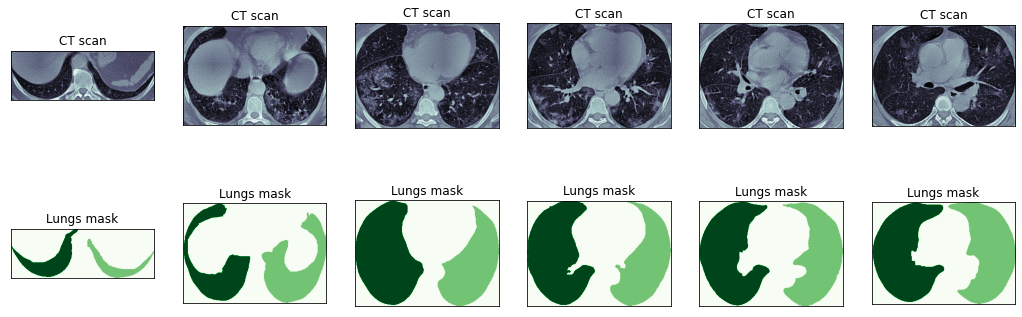

In [18]:
fig, axes = plt.subplots(2, 6, figsize=(18,6))

for ii in range(arr_cts.shape[0]):
    img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
   # img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    xmax, xmin = img_lungs.max(), img_lungs.min()
    img_lungs = (img_lungs - xmin)/(xmax - xmin)
    cropped_lungs, bounds = crop_img(img_lungs, [])

    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    #cropped_infec = crop_(img_infec, bounds)

    axes[0,ii].imshow(cropped_ct, cmap='bone')
    axes[0,ii].set_title("CT scan")
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])

    axes[1,ii].imshow(cropped_lungs, cmap='Greens')
    axes[1,ii].set_title("Lungs mask")
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    #axes[2,ii].imshow(cropped_infec, cmap='Reds')
    #axes[2,ii].set_title("Infection mask")
    #axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

### check

In [19]:
cts_all = []
lungs_all = []
#infects_all = []
max_w, max_h = 0, 0 #max width and height

for fnum in tqdm.tqdm(range(20)) : #range(metadata.shape[0])) :
    cts = nib.load(metadata.loc[fnum, 'ct_scan'])
    lungs = nib.load(metadata.loc[fnum, 'lung_mask'])
    #infec = nib.load(metadata.loc[fnum, 'infection_mask'])

    slices = cts.shape[2]

    arr_cts = cts.get_fdata()
    arr_lungs = lungs.get_fdata()
    #arr_infec = infec.get_fdata()

    arr_cts = np.rot90(np.array(arr_cts))
    arr_lungs = np.rot90(np.array(arr_lungs))
    #arr_infec = np.rot90(np.array(arr_infec))

    arr_cts = arr_cts[:, :, round(slices*0.2):round(slices*0.8)]
    arr_lungs = arr_lungs[:, :, round(slices*0.2):round(slices*0.8)]
    #arr_infec = arr_infec[:, :, round(slices*0.2):round(slices*0.8)]

    arr_cts = np.reshape(np.rollaxis(arr_cts, 2),
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
    arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2),
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
    #arr_infec = np.reshape(np.rollaxis(arr_infec, 2),
                    # (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1)

    for ii in range(arr_cts.shape[0]):
        img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size),
                              interpolation=cv.INTER_AREA)
        xmax, xmin = img_lungs.max(), img_lungs.min()
        img_lungs = (img_lungs - xmin)/(xmax - xmin)
        cropped_lungs, bounds = crop_img(img_lungs, [])
        lungs_all.append(cropped_lungs)

        h, w = cropped_img.shape
        max_h, max_w = max(max_h, h), max(max_w, w)

        img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size),interpolation=cv.INTER_AREA)
        xmax, xmin = img_ct.max(), img_ct.min()
        img_ct = (img_ct - xmin)/(xmax - xmin)
        clahe_ct = clahe_enhancer(img_ct, clahe, [])
        cropped_ct = crop_(clahe_ct, bounds)
        cts_all.append(cropped_ct)

       # img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size),
        #                      interpolation=cv.INTER_AREA)
        #cropped_infec = crop_(img_infec, bounds)
        #infects_all.append(cropped_infec)

100%|██████████| 20/20 [00:44<00:00,  2.22s/it]


In [20]:
print(len(cts_all))

2112


In [21]:
num_pix = 100
del_lst = []
for ii in tqdm.tqdm(range(len(cts_all))) :
    try :
        cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))

        lungs_all[ii] = cv.resize(lungs_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        lungs_all[ii] = np.reshape(lungs_all[ii], (num_pix, num_pix, 1))

        #infects_all[ii] = cv.resize(infects_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        #infects_all[ii] = np.reshape(infects_all[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)

for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    #del infects_all[idx]

100%|██████████| 2112/2112 [00:01<00:00, 1126.73it/s]


Text(0.5, 1.0, 'Lungs')

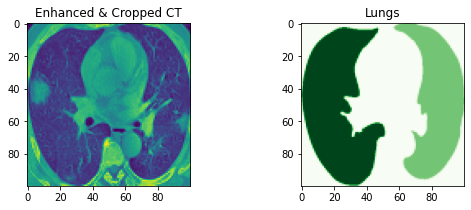

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

axes[0].imshow(cts_all[250][:, :, 0])
axes[0].set_title("Enhanced & Cropped CT")

axes[1].imshow(lungs_all[250][:, :, 0], cmap='Greens')
axes[1].set_title("Lungs")

#axes[2].imshow(infects_all[250][:, :, 0], cmap='Reds')
#axes[2].set_title("Infection");

In [23]:
with open('preprocessed_cts.cp', 'wb') as myfile:
    pickle.dump({'cts_all': cts_all, 'lungs_all': lungs_all}, myfile)

In [24]:
lung_bool = np.ones((1, len(lungs_all)))
for ii in range(len(lungs_all)):
    if np.unique(lungs_all[ii]).size == 1:
        lung_bool[0, ii] = 0

print("Number of CTs with no lung mask: %d" %(len(lungs_all)-lung_bool.sum()))

# for index in sorted(no_masks, reverse = True):
#    del infections[index]
#    del cts[index]

Number of CTs with no lung mask: 0


In [25]:
ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips

    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-15, 15)
    )
], random_order=True) # apply augmenters in random order

In [26]:
num_augs = round(len(cts_all)/2.)
rand_idx = np.random.randint(0, len(cts_all), size=num_augs)

sample_cts = [cts_all[ii] for ii in rand_idx]
sample_lungs = [lungs_all[ii] for ii in rand_idx]
#sample_infects = [infects_all[ii] for ii in rand_idx]

In [27]:
seq_det = seq.to_deterministic()
cts_aug = seq_det.augment_images(sample_cts)
lungs_aug = seq_det.augment_images(sample_lungs)
#infects_aug = seq_det.augment_images(sample_infects)

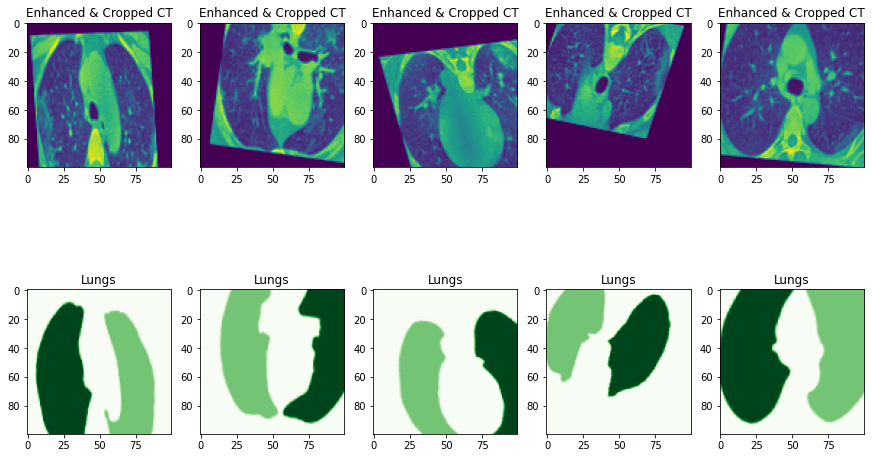

In [28]:
fig, axes = plt.subplots(2, 5, figsize=(15,9))

for ii in range(5) :
    axes[0, ii].imshow(cts_aug[ii*10+50][:, :, 0])
    axes[0, ii].set_title("Enhanced & Cropped CT")

    axes[1, ii].imshow(lungs_aug[ii*10+50][:, :, 0], cmap='Greens')
    axes[1, ii].set_title("Lungs")

    #axes[2, ii].imshow(infects_aug[ii*10+50][:, :, 0], cmap='Reds')
    #axes[2, ii].set_title("Infection");

In [29]:
cts_all = tf.convert_to_tensor(cts_all)
cts_aug = tf.convert_to_tensor(cts_aug)
lungs_all = tf.convert_to_tensor(lungs_all)
lungs_aug = tf.convert_to_tensor(lungs_aug)
#infects_all = tf.convert_to_tensor(infects_all)
#infects_aug = tf.convert_to_tensor(infects_aug)

cts = tf.concat([cts_all, cts_aug], axis=0)
lungs = tf.concat([lungs_all, lungs_aug], axis=0)
#infects = tf.concat([infects_all, infects_aug], axis=0)

2023-03-14 23:50:20.538088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38427 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:22:00.0, compute capability: 8.0
2023-03-14 23:50:20.539739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38427 MB memory:  -> device: 1, name: A100-PCIE-40GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2023-03-14 23:50:20.541324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38427 MB memory:  -> device: 2, name: A100-PCIE-40GB, pci bus id: 0000:9e:00.0, compute capability: 8.0
2023-03-14 23:50:20.542878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38427 MB memory:  -> device: 3, name: A100-PCIE-40GB, pci bus id: 0000:a2:00.0, compute 

In [30]:
indices = tf.range(start=0, limit=cts.shape[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

cts = tf.gather(cts, shuffled_indices)
lungs = tf.gather(lungs, shuffled_indices)
#infects = tf.gather(infects, shuffled_indices)

print(cts.shape, lungs.shape)

(3157, 100, 100, 1) (3157, 100, 100, 1)


In [31]:
with open('augmented_cts.cp', 'wb') as myfile:
    pickle.dump({'cts': cts, 'lungs': lungs}, myfile)

## Loss functions

In [35]:
## see https://github.com/keras-team/keras/issues/9395

def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred): #Binary Cross-Entropy
    loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha, beta  = 0.5, 0.5

    ones = K.ones(K.shape(y_true))
    p0 = y_pred
    p1 = ones-y_pred
    g0 = y_true
    g1 = ones-y_true

    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))

    T = K.sum(num/den)

    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) +
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) +
                     K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1*m2)
    score = (2.*K.sum(w*intersection) + smooth) / (K.sum(w*m1) + K.sum(w*m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1),
                             padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5.*K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

## Building model

In [36]:
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(callbacks.Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()

    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = np.floor(n_epochs/n_cycles)
        cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (np.cos(cos_inner) + 1)

    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

In [37]:
# define learning rate callback
n_epochs = 250
lrmax = 0.002
n_cycles = n_epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, lrmax)

In [38]:
def cts_block_1 (x_in, conv2Dfilters, maxpool2Dsize=(2,2)) :
    x = Conv2D(conv2Dfilters, (3,3), activation='relu', padding='same',
               kernel_initializer="he_normal") (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same',
               kernel_initializer="he_normal") (x)
    x_inter = BatchNormalization() (x)
    x = MaxPooling2D(maxpool2Dsize) (x_inter)
    x = Dropout(0.25)(x)

    return x, x_inter

def cts_block_2 (x_in, conv2Dfilters) :
    x = BatchNormalization() (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same',
               kernel_initializer="he_normal") (x)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same',
               kernel_initializer="he_normal") (x)

    return x

In [39]:
def cts_model (input_shape) :

    x_input = Input(input_shape)

    ##################################  LUNG SEGMENTATION  ######################
    x, x1 = cts_block_1 (x_input, 32, maxpool2Dsize=(2,2)) #x: 50x50
    x, x2 = cts_block_1 (x, 64, maxpool2Dsize=(2,2)) #x: 25x25
    x, _ = cts_block_1 (x, 128, maxpool2Dsize=(1,1)) #x: 25x25
    x, _ = cts_block_1 (x, 256, maxpool2Dsize=(1,1)) #x: 25x25

    x = cts_block_2 (x, 256) #x: 25x25

    x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x) #x: 50x50
    x = cts_block_2 (x, 128) #x: 50x50

    x = Conv2DTranspose(64, (2, 2), padding='same') (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = cts_block_2 (x, 64) #x: 50x50

    x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = cts_block_2 (x, 32) #x: 100x100

    lung_seg = Conv2D(1, (1, 1), activation='sigmoid', name='lung_output') (x) #x: 100x100

    ##################################  INFECTION SEGMENTATION  ######################


    model = Model(inputs=x_input, outputs=[lung_seg], name='cts_model')

    return model

In [40]:
ctsModel = cts_model(cts.shape[1:])
ctsModel.summary()

Model: "cts_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________

In [41]:
train_size = int(0.8*cts.shape[0])
test_size = int(0.1*cts.shape[0])

X_train, yl_train = (cts[:train_size]/255,
                               lungs[:train_size])


X_valid, yl_valid = (cts[train_size:train_size+test_size]/255,
                               lungs[train_size:train_size+test_size])


X_test, yl_test = (cts[train_size+test_size:]/255,
                            lungs[train_size+test_size:])


print(X_train.shape, yl_train.shape)
print(X_test.shape, yl_test.shape)

(2525, 100, 100, 1) (2525, 100, 100, 1)
(317, 100, 100, 1) (317, 100, 100, 1)


## Learning

In [42]:
batch_size = 128
epochs = n_epochs

checkpoint_fpath = "ctsmodel-lungs-seg.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_infect_output_dice_coeff', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

In [43]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow import keras

optim = keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.99)

loss_dict = {'lung_output': bce_dice_loss}
loss_weight_dict = {'lung_output': 1.0}

ctsModel.compile(optimizer=optim, loss=loss_dict, loss_weights=loss_weight_dict, metrics=[dice_coeff])

ctsRes = ctsModel.fit(x=X_train, 
                      y={'lung_output': yl_train}, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_valid, 
                                       {'lung_output': yl_valid}),
                      callbacks = [cts_checkpoint_cb, lr_cb])

2023-03-14 23:53:04.923832: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250


2023-03-14 23:53:08.327686: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


20/20 [==============================] - 12s 259ms/step - loss: 0.3560 - dice_coeff: 0.7077 - val_loss: 3.8098 - val_dice_coeff: 0.1605
Epoch 2/250
20/20 [==============================] - 2s 101ms/step - loss: 0.2640 - dice_coeff: 0.7774 - val_loss: 0.9623 - val_dice_coeff: 0.6247
Epoch 3/250
20/20 [==============================] - 2s 105ms/step - loss: 0.2390 - dice_coeff: 0.7923 - val_loss: 1.1878 - val_dice_coeff: 0.6355
Epoch 4/250
20/20 [==============================] - 2s 116ms/step - loss: 0.2286 - dice_coeff: 0.7990 - val_loss: 0.5249 - val_dice_coeff: 0.6412
Epoch 5/250
20/20 [==============================] - 2s 122ms/step - loss: 0.2201 - dice_coeff: 0.8047 - val_loss: 0.5663 - val_dice_coeff: 0.6576
Epoch 6/250
20/20 [==============================] - 2s 122ms/step - loss: 0.2154 - dice_coeff: 0.8080 - val_loss: 0.5442 - val_dice_coeff: 0.6154
Epoch 7/250
20/20 [==============================] - 2s 104ms/step - loss: 0.2121 - dice_coeff: 0.8092 - val_loss: 0.6992 - val_d

In [45]:
!mkdir weights

In [46]:
ctsModel.save('weights/model_4_v1.h5')

In [47]:
ctsModel_json = ctsModel.to_json()
with open('ctsModel-lungs.json', 'w') as myfile:
     myfile.write(ctsModel_json)

In [48]:
yl_pred = ctsModel.predict(X_test)
print(yl_pred.shape)

(317, 100, 100, 1)


In [49]:
score = ctsModel.evaluate(X_test, yl_test, verbose=2)
print("Dice Loss, Dice Coefficient:", score)

10/10 - 1s - loss: 0.1853 - dice_coeff: 0.8263
Dice Loss, Dice Coefficient: [0.18529266119003296, 0.826309084892273]


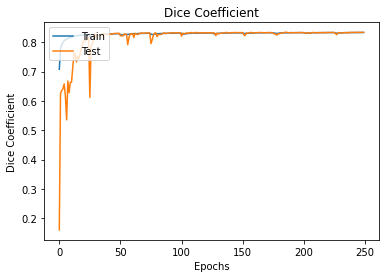

In [50]:
plt.plot(ctsRes.history['dice_coeff'])
plt.plot(ctsRes.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

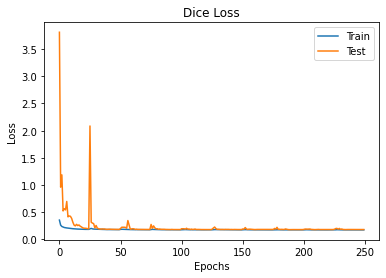

In [51]:
plt.plot(ctsRes.history['loss'])
plt.plot(ctsRes.history['val_loss'])
plt.title('Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

In [52]:
# Restore the weights
ctsModel.load_weights('/content/drive/MyDrive/Weights/model_4_v1.h5')

# Evaluate the model
loss, acc =ctsModel.evaluate(X_test, yl_test, verbose=2)
print("Restored model, Dice Coefficient: {:5.2f}%".format(100 * acc))

OSError: Unable to open file (unable to open file: name = '/content/drive/MyDrive/Weights/model_4_v1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))
    for i in range(len(X_test)):
        plt.subplot(2,3,1)
        plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
        plt.title('Original Image (CT)')

        plt.subplot(2,3,2)
        plt.imshow(tf.reshape(yl_test[img_num], [num_pix, num_pix]), cmap='bone')
        plt.title('Actual lung mask')

    #plt.subplot(2,3,3)
    #plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('infection mask')

        plt.subplot(2,3,3)
        plt.imshow(tf.reshape(yl_pred[img_num], [num_pix, num_pix]), cmap='bone')
        plt.title('Predicted lung mask')



   # plt.subplot(2,3,6)
   # plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('predicted infection mask')


compare_actual_and_predicted(165)

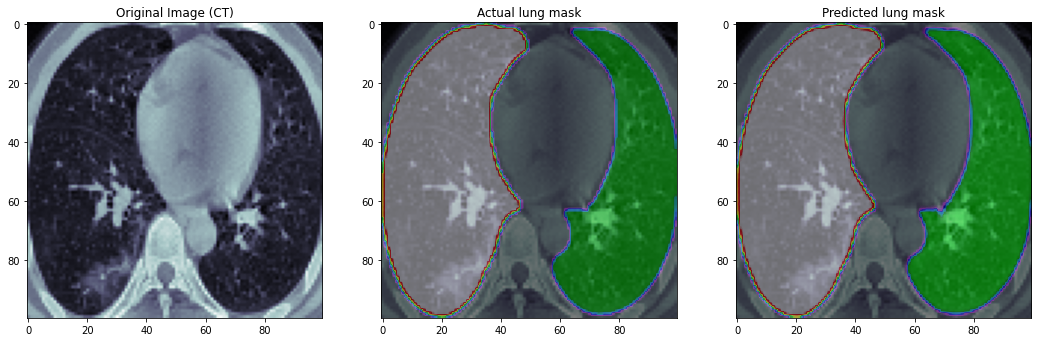

In [53]:
predicted = ctsModel.predict(X_test)
fig = plt.figure(figsize = (18,15))


for i in range(len(X_test)):
    plt.subplot(1,3,1)
    plt.imshow(X_test[i][...,0], cmap = 'bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(X_test[i][...,0], cmap = 'bone')
    plt.imshow(yl_test[i][...,0],alpha = 0.5, cmap = "nipy_spectral")
    plt.title('Actual lung mask')

    plt.subplot(1,3,3)
    plt.imshow(X_test[i][...,0], cmap = 'bone')
    plt.imshow(predicted[i][...,0],alpha = 0.5,cmap = "nipy_spectral")
    plt.title('Predicted lung mask')

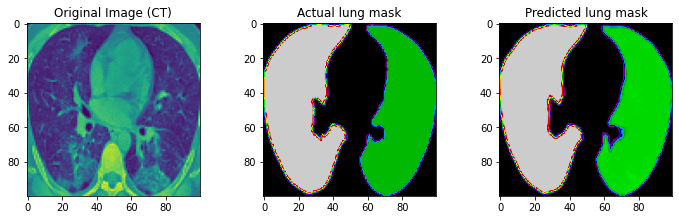

In [54]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('Original Image (CT)')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yl_test[img_num], [num_pix, num_pix]), cmap='nipy_spectral')
    plt.title('Actual lung mask')

    #plt.subplot(2,3,3)
    #plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('infection mask')

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yl_pred[img_num], [num_pix, num_pix]), cmap='nipy_spectral')
    plt.title('Predicted lung mask')

   # plt.subplot(2,3,6)
   # plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('predicted infection mask')


compare_actual_and_predicted(40)

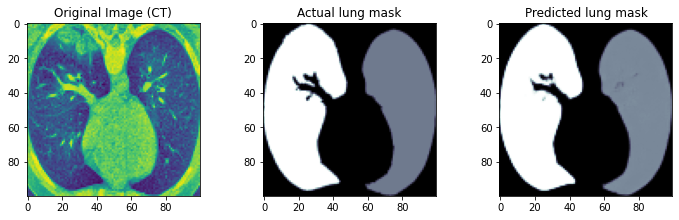

In [55]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('Original Image (CT)')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yl_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('Actual lung mask')



    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yl_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('Predicted lung mask')




compare_actual_and_predicted(200)

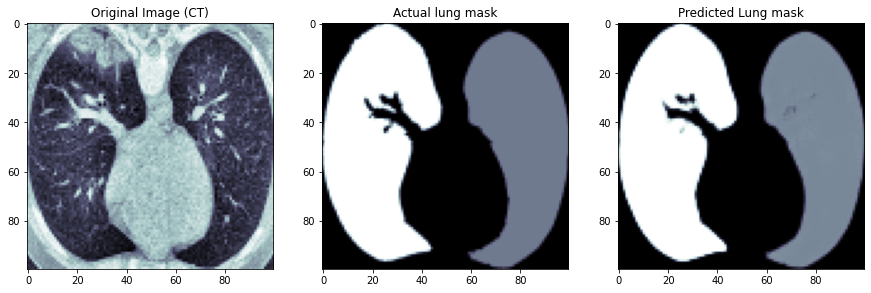

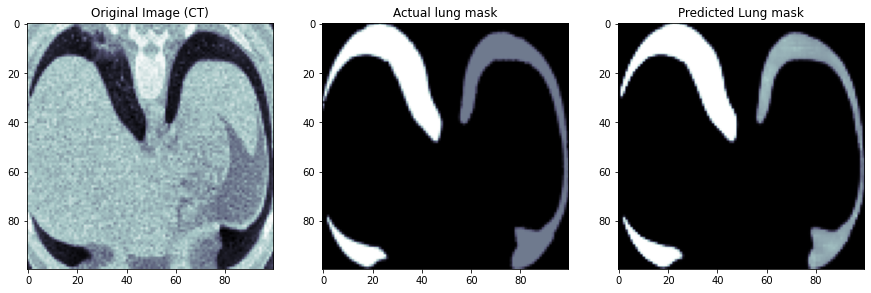

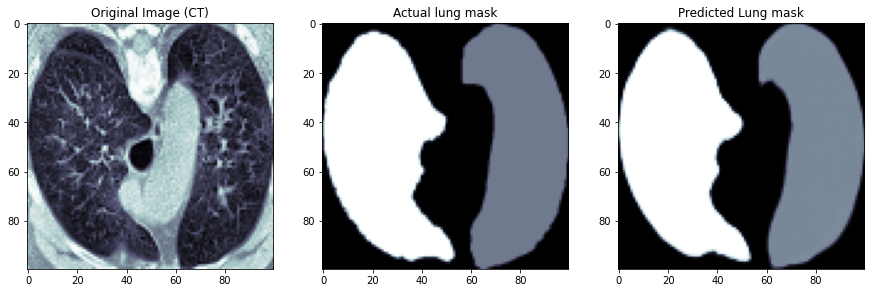

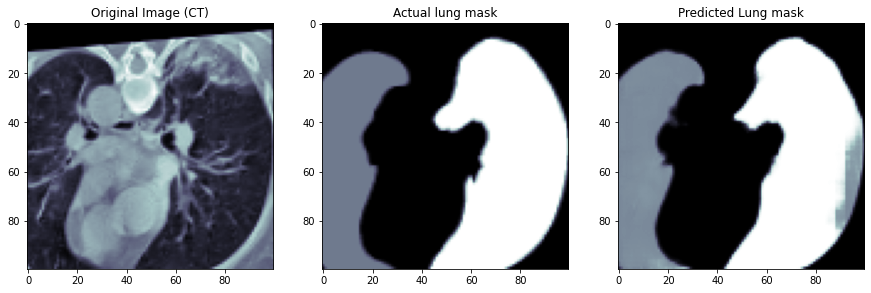

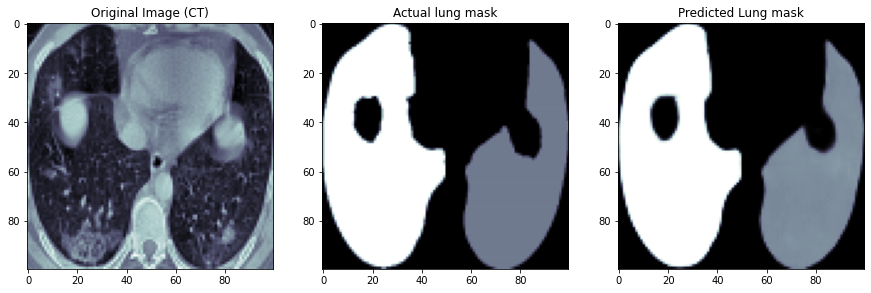

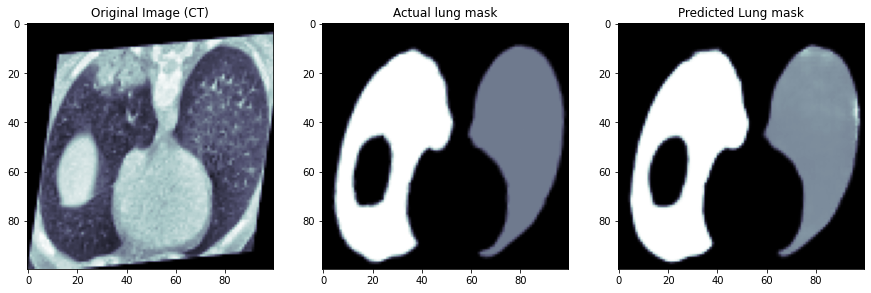

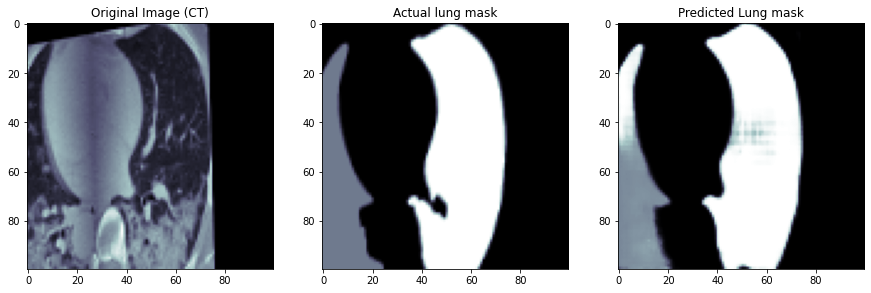

In [56]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def compare_actual_and_predicted(img_num):
    temp = ctsModel.predict(X_test[img_num].reshape(1,num_pix, num_pix,1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(X_test[img_num].reshape(num_pix, num_pix), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(yl_test[img_num].reshape(num_pix, num_pix), cmap='bone')
    plt.title('Actual lung mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(num_pix, num_pix), cmap='bone')
    plt.title('Predicted Lung mask')

    plt.show()
for i in [200,269,155, 255, 80, 90,51]:
    compare_actual_and_predicted(i)

In [57]:
the_range = np.arange(0.10,0.80, 0.05)

In [58]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [59]:
import segmentation_models as sm

dices=[]
ious=[]

for t in the_range:
    iou = sm.metrics.IOUScore(threshold=t)
    dice = sm.metrics.FScore(threshold=t)
    ctsModel.compile(optimizer=Adam(lr = 0.002), loss=bce_dice_loss, metrics=[dice, iou])
    score = ctsModel.evaluate(X_test, yl_test, batch_size=32) #X_test, yl_test
    dices.append(score[1])
    ious.append(score[2])

Segmentation Models: using `tf.keras` framework.
10/10 [==============================] - 1s 17ms/step - loss: 0.1853 - f1-score: 0.8005 - iou_score: 0.6674


In [60]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", the_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

DICES: [0.8487979173660278, 0.8513535261154175, 0.8529127240180969, 0.8539930582046509, 0.8546700477600098, 0.855095386505127, 0.8553311228752136, 0.855324923992157, 0.8550010919570923, 0.828830361366272, 0.8091169595718384, 0.8048281669616699, 0.802385687828064, 0.8004851341247559]
IOUS: [0.7373276948928833, 0.7411928772926331, 0.7435595989227295, 0.7452031373977661, 0.746234655380249, 0.7468834519386292, 0.7472434639930725, 0.7472342848777771, 0.7467401623725891, 0.7077146768569946, 0.6794665455818176, 0.6734551787376404, 0.6700499057769775, 0.6674094796180725]
Best Threshold: 0.40000000000000013
Best dice score: 0.8553311228752136
Best iou score: 0.7472434639930725


Best Threshold: 0.40000000000000013


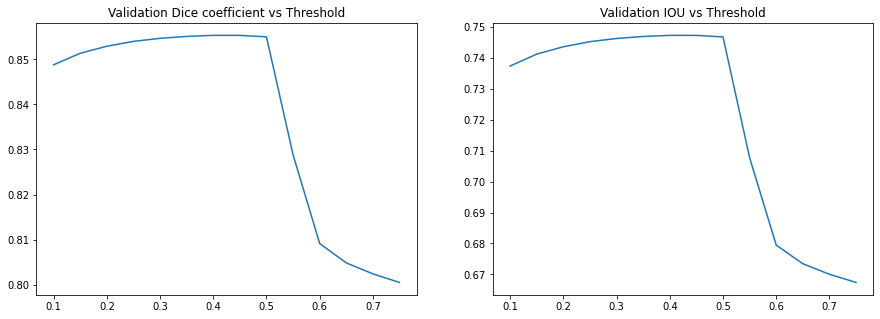

In [61]:
print("Best Threshold:", the_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [62]:
the_new_range = np.arange(0.43,0.53, 0.001)

In [63]:
new_dices=[]
new_ious=[]

for t in the_new_range:
    iou = sm.metrics.IOUScore(threshold=t)
    dice = sm.metrics.FScore(threshold=t)
    ctsModel.compile(optimizer=Adam(learning_rate=0.002), loss=bce_dice_loss, metrics=[dice, iou])
    score = ctsModel.evaluate(X_test, yl_test, batch_size=32)
    new_dices.append(score[1])
    new_ious.append(score[2])

10/10 [==============================] - 1s 16ms/step - loss: 0.1853 - f1-score: 0.8544 - iou_score: 0.7458


In [64]:
print('NEW DICES:',new_dices)
print("NEW IOUS:",new_ious)
print("New Best Threshold:", the_new_range[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])
print("Best new iou score:", new_ious[np.argmax(new_ious)])

NEW DICES: [0.8553544878959656, 0.8553565144538879, 0.8553563356399536, 0.8553533554077148, 0.8553549647331238, 0.855353057384491, 0.8553510904312134, 0.8553504943847656, 0.855349063873291, 0.8553489446640015, 0.8553465008735657, 0.8553460240364075, 0.8553433418273926, 0.8553394079208374, 0.8553386926651001, 0.855337917804718, 0.8553339242935181, 0.8553361892700195, 0.8553346395492554, 0.8553282022476196, 0.855324923992157, 0.8553217053413391, 0.8553193807601929, 0.8553153276443481, 0.8553133010864258, 0.855309784412384, 0.8553060293197632, 0.8553042411804199, 0.8552983999252319, 0.8552953600883484, 0.8552892804145813, 0.8552859425544739, 0.8552811741828918, 0.8552773594856262, 0.8552725911140442, 0.8552668690681458, 0.8552619814872742, 0.855258584022522, 0.855257511138916, 0.8552543520927429, 0.8552473187446594, 0.855240523815155, 0.8552346229553223, 0.8552276492118835, 0.8552206158638, 0.8552128076553345, 0.8552061319351196, 0.855199933052063, 0.8551931381225586, 0.8551863431930542, 

Best Threshold: 0.431


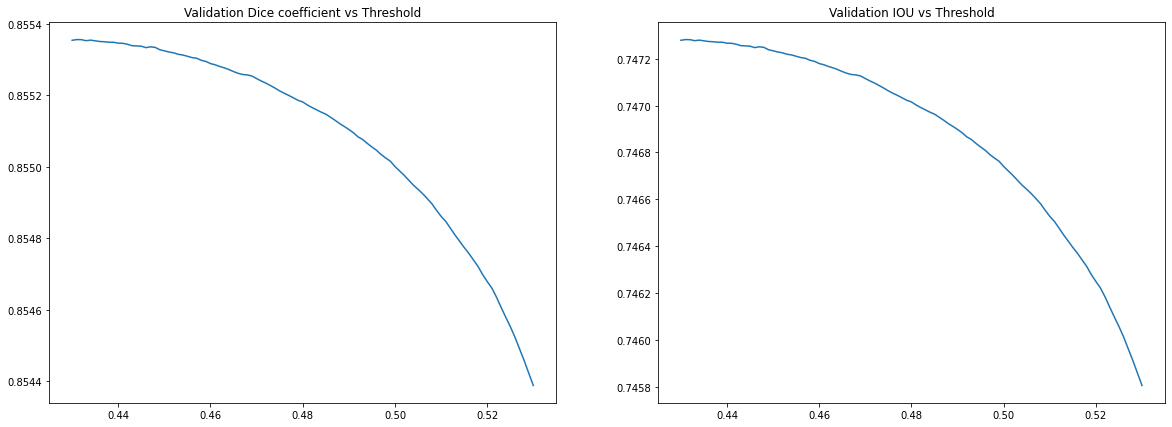

In [65]:
print("Best Threshold:", the_new_range[np.argmax(new_dices)])
fig = plt.figure(figsize=(20,7))

plt.subplot(1, 2, 1)
plt.plot(the_new_range, new_dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_new_range, new_ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [66]:
the_prec_rec_range = np.arange(0,1, 0.05)

In [67]:
precisions=[]
recalls=[]

for t in the_prec_rec_range:
    precision = sm.metrics.Precision(threshold=t)
    recall = sm.metrics.Recall(threshold=t)
    ctsModel.compile(optimizer=Adam(learning_rate=0.002), loss=bce_dice_loss, metrics=[precision, recall])
    score = ctsModel.evaluate(X_test, yl_test, batch_size=32)
    precisions.append(score[1])
    recalls.append(score[2])

10/10 [==============================] - 1s 18ms/step - loss: 0.1853 - precision: 0.9935 - recall: 0.6519


In [68]:
print('PRECISIONS:',precisions)
print("RRECALLS:",recalls)
print("Best Threshold for Precision:", the_prec_rec_range[np.argmax(precisions)])
print("Best Threshold for Recall:", the_prec_rec_range[np.argmax(recalls)])
print("Best precision score:", precisions[np.argmax(precisions)])
print("Best recall score:", recalls[np.argmax(recalls)])

PRECISIONS: [0.37821274995803833, 0.731963038444519, 0.7410621047019958, 0.746533989906311, 0.7504628300666809, 0.7537198066711426, 0.7564407587051392, 0.758892834186554, 0.7612853050231934, 0.7637776732444763, 0.7667279839515686, 0.869317352771759, 0.9583919644355774, 0.9728527069091797, 0.9791614413261414, 0.98260098695755, 0.9855645895004272, 0.9881852269172668, 0.9907048344612122, 0.9935173988342285]
RRECALLS: [1.0, 0.9961760640144348, 0.9932038187980652, 0.9904299974441528, 0.9877699017524719, 0.9850522875785828, 0.9822292327880859, 0.9792399406433105, 0.9758979678153992, 0.9718160629272461, 0.9662536382675171, 0.7924478054046631, 0.7002302408218384, 0.6863939762115479, 0.6797634363174438, 0.675402045249939, 0.6711875796318054, 0.6667340993881226, 0.6610370874404907, 0.6519303917884827]
Best Threshold for Precision: 0.9500000000000001
Best Threshold for Recall: 0.0
Best precision score: 0.9935173988342285
Best recall score: 1.0


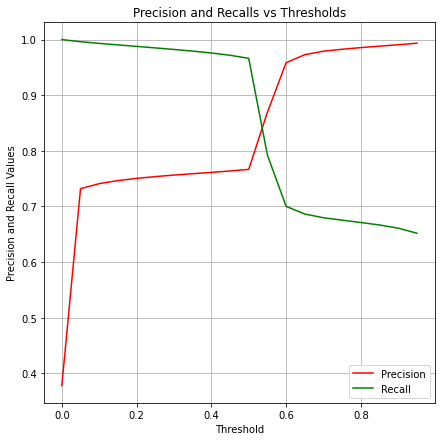

In [69]:
from pylab import rcParams

rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])

# Test dataset

In [75]:
!rm -r Moscow_Medicine_data

In [76]:
url = 'https://drive.google.com/file/d/17mnGpdOheOHd0XxydY6ghQVdXp8Vx94c/view?usp=share_link'
output_path = 'moscow_med_test_data.zip'
gdown.download(url, output_path, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=17mnGpdOheOHd0XxydY6ghQVdXp8Vx94c
To: /home/jovyan/moscow_med_test_data.zip
100%|██████████| 80.0M/80.0M [00:01<00:00, 58.1MB/s]


'moscow_med_test_data.zip'

In [77]:
!mkdir Moscow_Medicine_data
!unzip moscow_med_test_data.zip -d Moscow_Medicine_data/
!rm -r moscow_med_test_data.zip

Archive:  moscow_med_test_data.zip
 extracting: Moscow_Medicine_data/image00002.png  
 extracting: Moscow_Medicine_data/image00089.png  
 extracting: Moscow_Medicine_data/image00003.png  
 extracting: Moscow_Medicine_data/image00090.png  
 extracting: Moscow_Medicine_data/image00004.png  
 extracting: Moscow_Medicine_data/image00005.png  
 extracting: Moscow_Medicine_data/image00006.png  
 extracting: Moscow_Medicine_data/image00007.png  
 extracting: Moscow_Medicine_data/image00008.png  
 extracting: Moscow_Medicine_data/image00009.png  
 extracting: Moscow_Medicine_data/image00010.png  
 extracting: Moscow_Medicine_data/image00011.png  
 extracting: Moscow_Medicine_data/image00012.png  
 extracting: Moscow_Medicine_data/image00013.png  
 extracting: Moscow_Medicine_data/image00091.png  
 extracting: Moscow_Medicine_data/image00014.png  
 extracting: Moscow_Medicine_data/image00015.png  
 extracting: Moscow_Medicine_data/image00016.png  
 extracting: Moscow_Medicine_data/image00017.pn

In [78]:
from PIL import Image, ImageFilter
import os
import cv2
import numpy as np

In [79]:
# PATH_TO_TEST_DATA = '/content/Moscow_Medicine_data/'

# for i in os.listdir(PATH_TO_TEST_DATA):
#     im = Image.open(PATH_TO_TEST_DATA + i)
#     im = im.rotate(17, expand=False, fillcolor='black')
#     im = im.resize((512, 512), Image.LANCZOS)

#     # Add sharpening with radius=2 and amount=150
#     im = im.filter(ImageFilter.UnsharpMask(radius=2, percent=150))

#     # Add detail enhancement with radius=1, threshold=10, and factor=2
#     detail = im.filter(ImageFilter.UnsharpMask(radius=1, threshold=10))
#     im = Image.blend(im, detail, 0.5)

#     im.save(PATH_TO_TEST_DATA + i, quality=100)
#     im.close();

In [81]:
import os
from PIL import Image, ImageFilter, ImageChops

PATH_TO_TEST_DATA = 'Moscow_Medicine_data/'

kernel_size = 10

for i in os.listdir(PATH_TO_TEST_DATA):
    im = Image.open(PATH_TO_TEST_DATA + i)
    im = im.rotate(17, expand=False, fillcolor='black')
    im = im.resize((512, 512), Image.LANCZOS)

    # Add sharpening with radius=2 and amount=150
    im = im.filter(ImageFilter.UnsharpMask(radius=2, percent=150))

    # Add detail enhancement with radius=1, threshold=10, and factor=2
    detail = im.filter(ImageFilter.UnsharpMask(radius=3, threshold=10))
    im = Image.blend(im, detail, 0.5)

    # Convert image to grayscale and create a binary mask
    gray = im.convert('L')
    mask = gray.point(lambda x: 255 if x > 100 else 0, mode='1')

    # Convert the mask to the same mode as the original image
    mask = mask.convert(im.mode)

    # Apply Gaussian blur to the mask image to create a smooth edge
    mask = mask.filter(ImageFilter.GaussianBlur(radius=kernel_size))

    # Combine the smoothed edges with the original image
    im_edges = ImageChops.multiply(im, mask)
    im_smoothed = ImageChops.multiply(im, ImageChops.invert(mask))
    im_smoothed = im_smoothed.filter(ImageFilter.GaussianBlur(radius=kernel_size))

    # Combine the smoothed edges with the original image
    im_final = ImageChops.add(im_edges, im_smoothed)

    im_final.save(PATH_TO_TEST_DATA + i, quality=100)
    im_final.close()


In [82]:
import random
import matplotlib.pyplot as plt

random.seed(0) # set seed for reproducibility

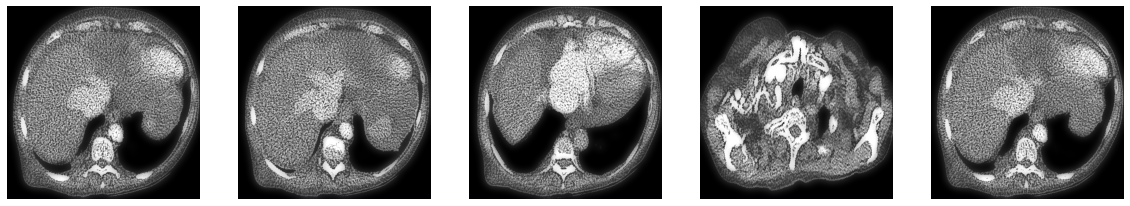

In [83]:
# Get a list of the processed images
images = [Image.open(os.path.join(PATH_TO_TEST_DATA, i)) for i in os.listdir(PATH_TO_TEST_DATA)]

# Choose 5 random images to plot
random_images = random.sample(images, 5)

# Plot the images using matplotlib
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, im in enumerate(random_images):
    axes[i].imshow(im, cmap='gray')
    axes[i].axis('off')

plt.show()

# Processing like Unet model 4

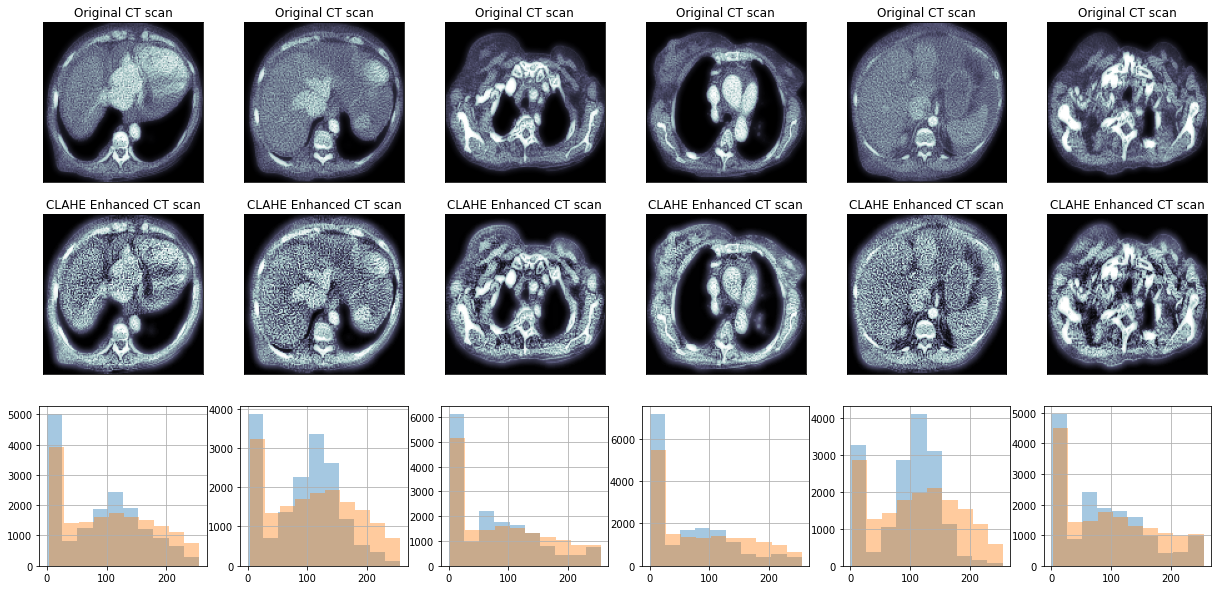

In [85]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_dir = "Moscow_Medicine_data"
img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
img_size = 128

clahe = cv2.createCLAHE(clipLimit=3.0)

def clahe_enhancer(img, clahe, axes):
    '''Contract Limited Adaptive Histogram Equalizer'''
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
        
    return(clahe_img)

fig, axes = plt.subplots(3, 6, figsize=(21,10))    

ii = 0
for img_file in img_files[::-1]:
    # Load the image
    img = cv2.imread(os.path.join(img_dir, img_file), cv2.IMREAD_GRAYSCALE)

    # Resize the image
    img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)

    # Normalize the pixel values
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)

    # Apply CLAHE
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))
    
    
    ii += 1
    if ii >= 6:
        break

In [86]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv2.filter2D(img, -1, kernel)
    
    ret, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, 2, 1)
    #Areas = [cv2.contourArea(cc) for cc in contours]; print(Areas)
    
    # filter contours that are too large or small
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv2.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    # margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv2.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds


def crop_img(img, axes) :
    contours = get_contours(img)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds

image00639.png
image00638.png
image00637.png
image00636.png
image00635.png
image00634.png
image00633.png
image00632.png
image00631.png
image00630.png
image00629.png
image00628.png
image00627.png
image00626.png
image00625.png
image00624.png
image00623.png
image00622.png
image00621.png
image00620.png
image00619.png
image00618.png
image00617.png
image00616.png
image00615.png
image00614.png
image00613.png
image00612.png
image00611.png
image00610.png
image00609.png
image00608.png
image00607.png
image00606.png
image00605.png
image00604.png
image00603.png
image00602.png
image00601.png
image00600.png
image00599.png
image00598.png
image00597.png
image00596.png
image00595.png
image00594.png
image00593.png
image00592.png
image00591.png
image00590.png
image00589.png
image00588.png
image00587.png
image00586.png
image00585.png
image00584.png
image00583.png
image00582.png
image00581.png
image00580.png
image00579.png
image00578.png
image00577.png
image00576.png
image00575.png
image00574.png
image00573

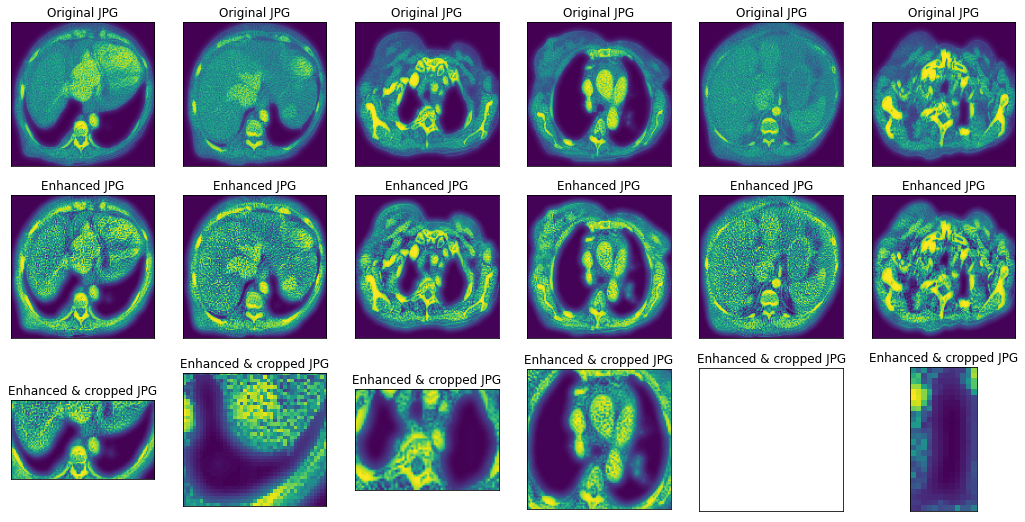

In [87]:
img_dir = "Moscow_Medicine_data"
img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
img_size = 128
cts_all = []

fig, axes = plt.subplots(3, 6, figsize=(18, 9))

ii = 0
for img_file in img_files[::-1]:
    print(img_file)
    # Load the image
    img = cv2.imread(os.path.join(img_dir, img_file), cv2.IMREAD_GRAYSCALE)    

    resized_img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = resized_img.max(), resized_img.min()
    normalized_img = (resized_img - xmin) / (xmax - xmin)
    _, bounds = crop_img(normalized_img, [])

    if ii < 6:
        axes[0, ii].imshow(np.uint8(normalized_img*255))
        axes[0, ii].set_title('Original JPG')
        axes[0, ii].set_xticks([]); axes[0, ii].set_yticks([])

    clahe_img = clahe_enhancer(normalized_img, clahe, [])
    if ii < 6:
        axes[1, ii].imshow(clahe_img)
        axes[1, ii].set_title('Enhanced JPG')
        axes[1, ii].set_xticks([]); axes[1, ii].set_yticks([])

    cropped_img = crop_(clahe_img, bounds)
    if ii < 6:
        axes[2, ii].imshow(cropped_img)
        axes[2, ii].set_title('Enhanced & cropped JPG')
        axes[2, ii].set_xticks([]); axes[2, ii].set_yticks([])

    ii += 1
    cts_all.append(cropped_img)

In [88]:
print(len(cts_all))

638


In [89]:
num_pix = 100
del_lst = []
for ii in tqdm.tqdm(range(len(cts_all))) :
    try :
        cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)

for idx in del_lst[::-1] :
    del cts_all[idx]

100%|██████████| 638/638 [00:00<00:00, 43575.41it/s]


посмотреть что такое x test

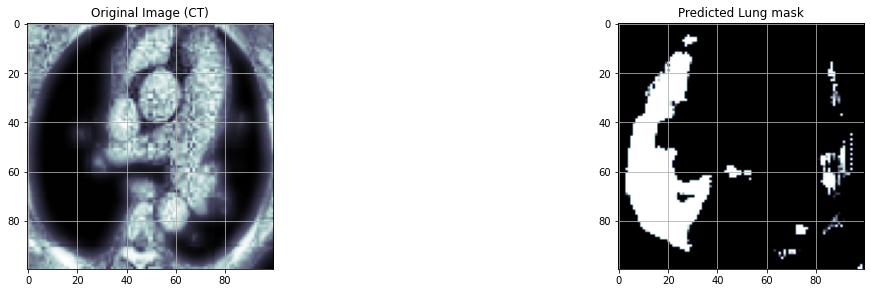

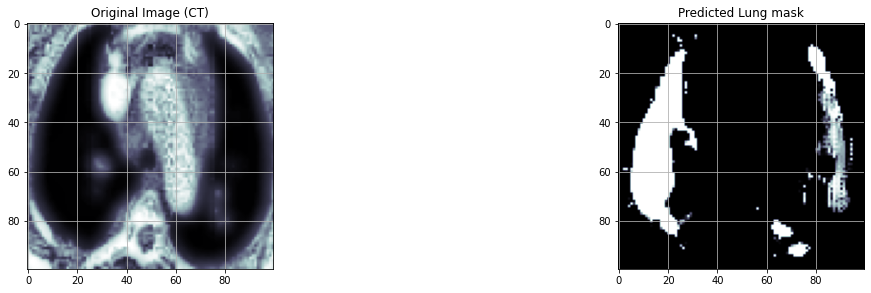

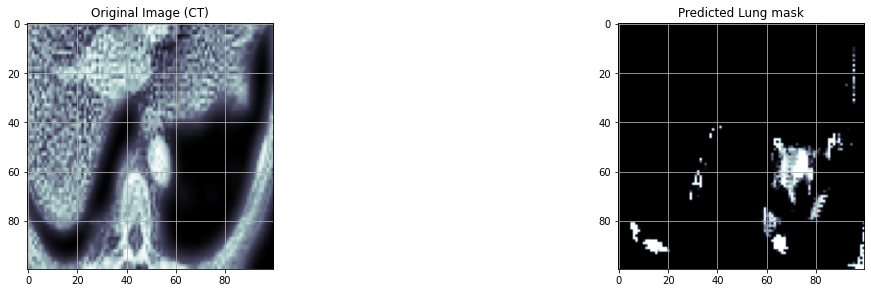

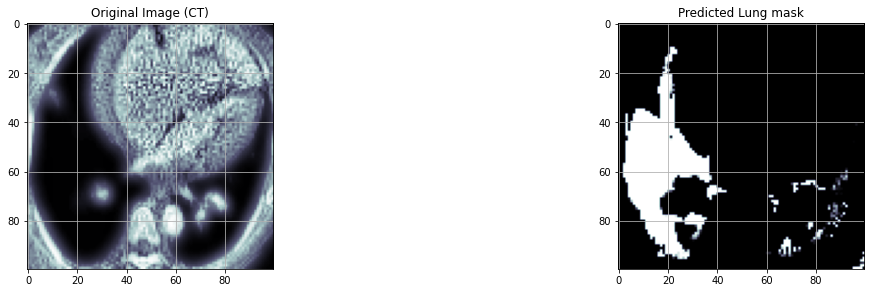

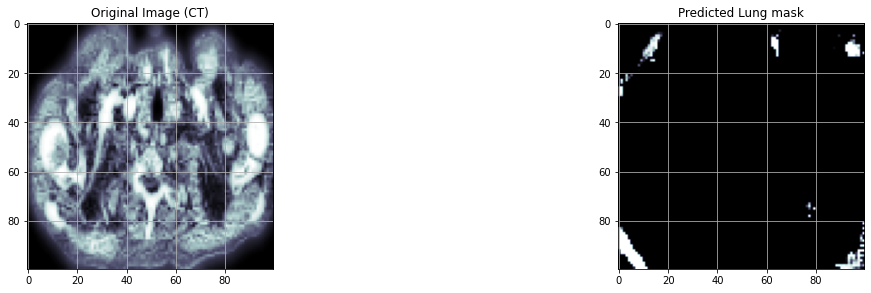

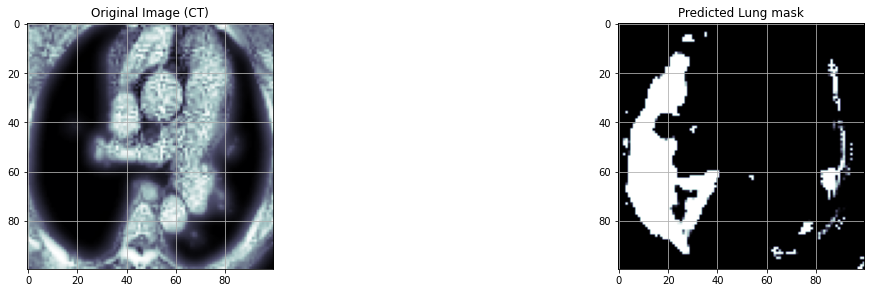

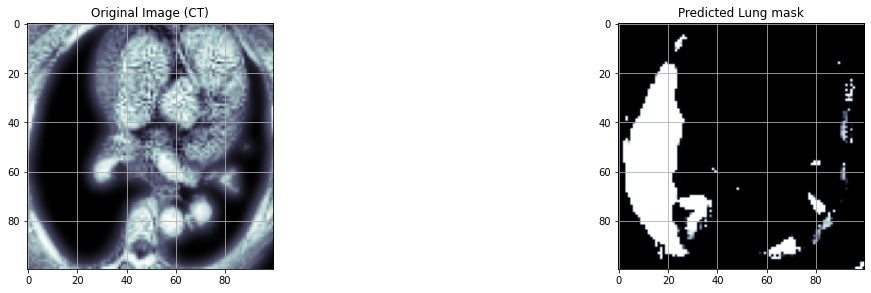

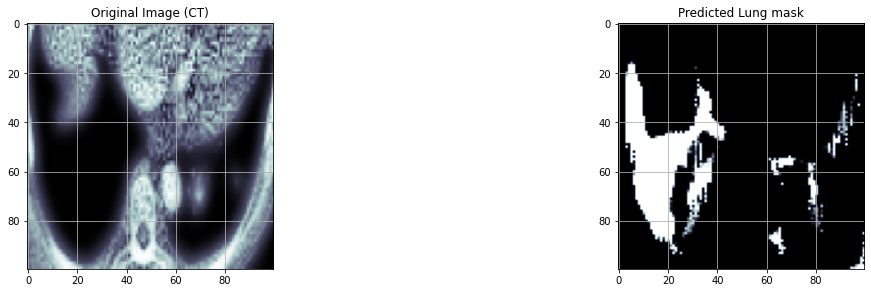

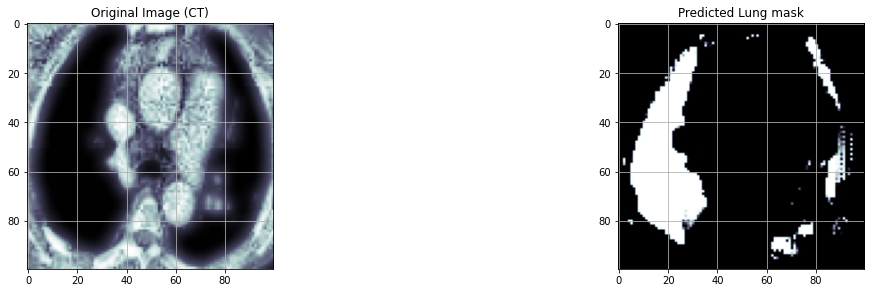

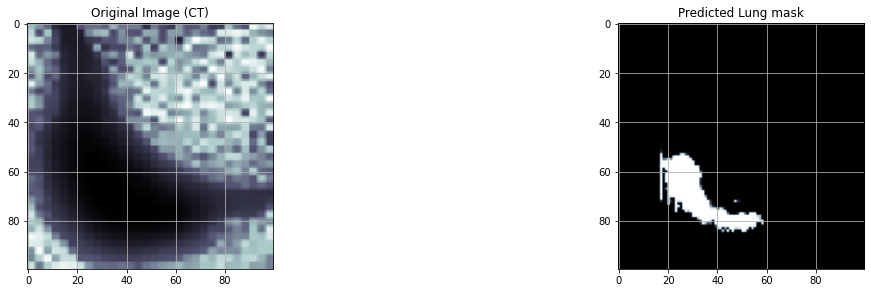

In [92]:
from tensorflow.python.ops.numpy_ops import np_config


np_config.enable_numpy_behavior()
def compare_actual_and_predicted(img_num):
    temp = ctsModel.predict(cts_all[img_num].reshape(1,num_pix, num_pix,1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(cts_all[img_num].reshape(num_pix, num_pix), cmap='bone')
    plt.title('Original Image (CT)')

    # plt.subplot(1,3,2)
    # plt.imshow(yl_test[img_num].reshape(num_pix, num_pix), cmap='bone')
    # plt.title('Actual lung mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(num_pix, num_pix), cmap='bone')
    plt.title('Predicted Lung mask')
    
    plt.savefig(f'sample_pred_{img_num}.png', bbox_inches='tight')

    plt.show()


for i in [200,269,155, 255, 80, 90,51, 100, 130, 300]:
    compare_actual_and_predicted(i)